#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

#### Loading Data

In [2]:
train = pd.read_csv('train_E1GspfA.csv', parse_dates=['date'])
test = pd.read_csv('test_6QvDdzb.csv', parse_dates=['date'])
print (train.shape, test.shape)

train['datetime'] = pd.to_datetime(train['date'].astype(str)+' '+train['hour'].astype(str)+':00')
test['datetime'] = pd.to_datetime(test['date'].astype(str)+' '+test['hour'].astype(str)+':00')

print ('train data is from {} to {}'.format(train['datetime'].min(), train['datetime'].max()))
print ('test data is from {} to {}'.format(test['datetime'].min(), test['datetime'].max()))

full_data = pd.concat([train, test])
print (full_data.shape)

(18247, 3) (7650, 2)
train data is from 2018-08-18 09:00:00 to 2021-02-28 23:00:00
test data is from 2021-03-01 00:00:00 to 2022-03-28 23:00:00
(25897, 4)


(array([1.320e+03, 2.475e+03, 3.007e+03, 3.205e+03, 3.284e+03, 2.582e+03,
        1.198e+03, 4.990e+02, 2.550e+02, 1.290e+02, 1.040e+02, 5.200e+01,
        5.300e+01, 3.400e+01, 1.900e+01, 1.200e+01, 1.000e+01, 5.000e+00,
        2.000e+00, 2.000e+00]),
 array([  1. ,  19.9,  38.8,  57.7,  76.6,  95.5, 114.4, 133.3, 152.2,
        171.1, 190. , 208.9, 227.8, 246.7, 265.6, 284.5, 303.4, 322.3,
        341.2, 360.1, 379. ]),
 <BarContainer object of 20 artists>)

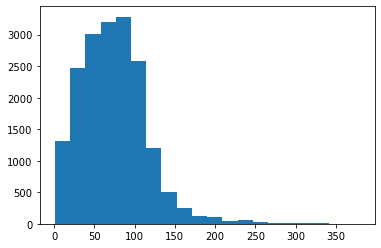

In [3]:
plt.hist(train['demand'], bins=20)

In [4]:
# creating date specific features
full_data['year'] = full_data['datetime'].dt.year
full_data['month'] = full_data['datetime'].dt.month
full_data['day'] = full_data['datetime'].dt.day
full_data['weekofyear'] = full_data['datetime'].dt.weekofyear
full_data['dayofyear'] = full_data['datetime'].dt.dayofyear
full_data['weekday'] = full_data['datetime'].dt.weekday
full_data['hrs_since_previous'] = (full_data['datetime']-full_data['datetime'].shift(1)).dt.seconds/3600

In [5]:
# # demand last year(same time) column
# df = full_data[['demand']]
# df.columns = ['demand_last_year']
# df['datetime'] = pd.to_datetime(full_data['day'].astype(str)+'-'+full_data['month'].astype(str)+'-'+(full_data['year']+1).astype(str)+' '+full_data['hour'].astype(str)+':00', errors='coerce')
# full_data = pd.merge(full_data, df, 'left')


# # building aggregating features from demand same day last year
# df = full_data.groupby(['year','month','day']).agg({'demand':['mean','median','min','max','std','count']}).reset_index()
# df.columns = df.columns.get_level_values(0)+df.columns.get_level_values(1)
# df['year'] = df['year']+1
# df = df.rename(columns={'demandmean':'demand_mean_last_year_day','demandmedian':'demand_median_last_year_day',
#                         'demandmin':'demand_min_last_year_day','demandmax':'demand_max_last_year_day',
#                         'demandstd':'demand_std_last_year_day','demandcount':'demand_count_last_year_day'})
# full_data = pd.merge(full_data, df, 'left')


# # building aggregating features from demand same month last year
# df = full_data.groupby(['year','month']).agg({'demand':['mean','median','min','max','std','count']}).reset_index()
# df.columns = df.columns.get_level_values(0)+df.columns.get_level_values(1)
# df['year'] = df['year']+1
# df = df.rename(columns={'demandmean':'demand_mean_last_year_month','demandmedian':'demand_median_last_year_month',
#                         'demandmin':'demand_min_last_year_month','demandmax':'demand_max_last_year_month',
#                         'demandstd':'demand_std_last_year_month','demandcount':'demand_count_last_year_month'})
# full_data = pd.merge(full_data, df, 'left')
# del df

In [6]:
train_df = full_data[~full_data['demand'].isnull()]
test_df = full_data[full_data['demand'].isnull()]

<AxesSubplot:xlabel='weekday', ylabel='demand'>

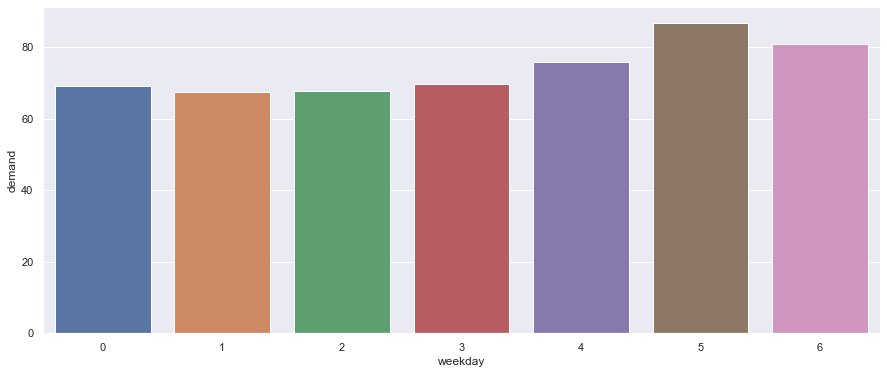

In [7]:
df = train_df.groupby('weekday').agg({'demand':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(data=df, x='weekday', y='demand')

* As expected, the average demand is high during weekend

In [8]:
drop_cols = ['date','datetime','demand']
cols_for_model = list(set(train_df.columns)-set(drop_cols))

cb_scores, pred_cb, feat_scores = [], [], []
for idxT, idxV in KFold(n_splits=5).split(train_df):
    df_trainX, df_trainY = train_df.iloc[idxT][cols_for_model], train_df.iloc[idxT]['demand']
    df_evalX, df_evalY = train_df.iloc[idxV][cols_for_model], train_df.iloc[idxV]['demand']
    
    cb = CatBoostRegressor(learning_rate=0.01, n_estimators=4000, random_state=123, early_stopping_rounds=50, eval_metric='RMSE')
    cb.fit(df_trainX, df_trainY, eval_set=(df_evalX,df_evalY), plot=False, verbose=0)
    cb_scores.append(cb.get_best_score().get('validation').get('RMSE'))
    print ('{} at {}'.format(cb.get_best_score().get('validation').get('RMSE'),cb.get_best_iteration()))
        
    pred_cb.append(cb.predict(test_df[cols_for_model]))
    feat_scores.append(cb.get_feature_importance())

weights = 1/np.array(cb_scores)
weights = weights/np.sum(weights)
print ('The Local CV is {}'.format(np.sum(weights*cb_scores)))

sub = test_df[['date','hour']]
sub['demand'] = np.sum(weights*np.transpose(pred_cb),1)
sub.to_csv('submit.csv', index=False)

36.60932719816931 at 201
32.35894425392193 at 2808
36.4724760256407 at 1658
32.74350777276769 at 2660
36.50287083561776 at 1359
The Local CV is 34.82567221675844


In [9]:
featureImp=pd.DataFrame({'feature':cols_for_model,'importance':np.mean(np.array(feat_scores),0)})
featureImp=featureImp.sort_values('importance',ascending=False)
featureImp['importance']=featureImp['importance']*100/featureImp['importance'].sum()
featureImp.reset_index(drop=True)

,feature,importance
0,hour,37.551034
1,dayofyear,23.280157
2,weekday,12.305653
3,weekofyear,9.395625
4,year,6.190989
5,month,5.669545
6,day,5.090653
7,hrs_since_previous,0.516342
